In [1]:
!pip install -U segmentation-models

In [2]:
!pip install patchify

# **All neccessary packages**

In [3]:
import os
import io
import cv2
import numpy as np
import array as arr
from PIL import Image
import tensorflow as tf
from tabulate import tabulate
import ipywidgets as widgets
import matplotlib.pyplot as plt
from contextlib import nullcontext
from IPython.display import display
from IPython.display import clear_output
from google.colab.patches import cv2_imshow
from keras.models import *
from google.colab import drive
from keras import backend as K
import segmentation_models as sm
from patchify import patchify

Segmentation Models: using `keras` framework.


# **Train Model**

# **Load Model**

1/1 [==============================] - 0s 423ms/step
(1, 256, 256)


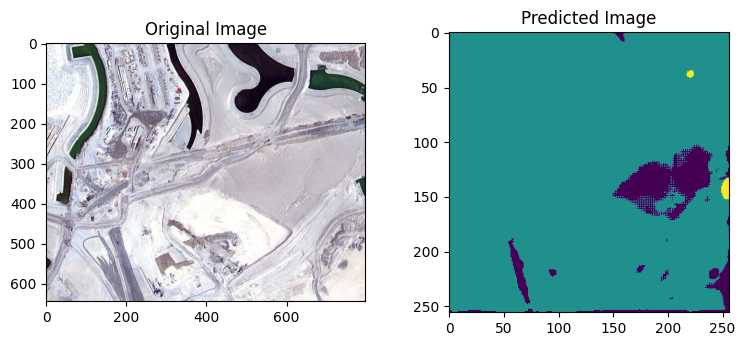

In [6]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# Clear the TensorFlow session to avoid potential conflicts
tf.keras.backend.clear_session()

def jaccard_coef(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value

metrics = ["accuracy", jaccard_coef]

saved_model = load_model('/content/drive/MyDrive/Group A.I. works/Trainedmodel/satellite_segmentation_full.h5',
                         custom_objects={'dice_loss_plus_1focal_loss': total_loss, 'jaccard_coef': jaccard_coef})

image_path = '/content/drive/MyDrive/Group A.I. works/DubaiDataset/Tile 1/images/image_part_001.jpg'
image = Image.open(image_path)
image = image.resize((256, 256))
image = np.array(image)
image = np.expand_dims(image, 0)
prediction = saved_model.predict(image)
predicted_image = np.argmax(prediction, axis=3)
predicted_image1 = np.argmax(prediction, axis=3).astype(np.uint8)
print(predicted_image1.shape)
predicted_image = predicted_image[0, :, :]
plt.figure(figsize=(14, 8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open(image_path))

plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)
plt.show()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Mask Image Generation by predicting**

In [7]:
def predicted_mask(img):
  img = img.resize((256, 256))
  img = np.array(img)
  img = np.expand_dims(img, 0)
  return np.argmax(saved_model.predict(img), axis=3)[0, :, :]

# **Report Generation function from predicted image**

In [8]:
def create_binary_mask(masked_image, target_color):
    lower_color = np.array(target_color, dtype=np.uint8)
    upper_color = np.array(target_color, dtype=np.uint8)
    x=cv2.inRange(masked_image, lower_color, upper_color)
    return x

In [9]:
def Regions_Area_Percentage(x_binary_masked_img,original_img,class_name):
  total_area=1000*1000 #Here let's assume total actual area is 1000000 KM^2
  total_pixels=original_img.shape[0]*original_img.shape[1]
  x_pixels = cv2.countNonZero(x_binary_masked_img)
  return((total_area/total_pixels)*x_pixels,(x_pixels/total_pixels)*100,class_name)

In [10]:
def generate_report(img_original,img_pred,current_year):
  img=img_original
  masked_img=img_pred
  building_mask_color=(152,16,60)
  tree_mask_color=(58,221,254)
  water_mask_color=(41,169,226)
  land_mask_color=(246,41,132)
  road_mask_color=(228,193,110)
  bridge_mask_color=road_mask_color
  green=(0,255,0)
  red=(0,0,255)
  blue=(255,0,0)
  road_binary_mask=create_binary_mask(masked_img, road_mask_color)
  water_binary_mask=create_binary_mask(masked_img, water_mask_color)
  tree_binary_mask=create_binary_mask(masked_img, tree_mask_color)
  building_binary_mask=create_binary_mask(masked_img, building_mask_color)
  land_binary_mask=create_binary_mask(masked_img, land_mask_color)

  water_edges = cv2.Canny(water_binary_mask, 100, 100)
  water_dilated_edges = cv2.dilate(water_edges, None, iterations=1)
  water_contours, _ = cv2.findContours(water_dilated_edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  water_contoured_mask = np.zeros_like(water_binary_mask)
  cv2.drawContours(water_contoured_mask, water_contours, -1, (255, 193, 0), 1)

  road_edges = cv2.Canny(road_binary_mask, 100, 100)
  road_dilated_edges = cv2.dilate(road_edges, None, iterations=1)
  road_contours, _ = cv2.findContours(road_dilated_edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  road_contoured_mask = np.zeros_like(road_binary_mask)
  cv2.drawContours(road_contoured_mask, road_contours, -1, (255, 193, 0), 1)

  building_edges = cv2.Canny(building_binary_mask, 100, 100)
  building_dilated_edges = cv2.dilate(building_edges, None, iterations=1)
  building_contours, _ = cv2.findContours(building_dilated_edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  building_contoured_mask = np.zeros_like(building_binary_mask)
  cv2.drawContours(building_contoured_mask, building_contours, -1, (255, 193, 0), 1)

  tree_edges = cv2.Canny(tree_binary_mask, 100, 100)
  tree_dilated_edges = cv2.dilate(tree_edges, None, iterations=1)
  tree_contours, _ = cv2.findContours(tree_dilated_edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  tree_contoured_mask = np.zeros_like(tree_binary_mask)
  cv2.drawContours(tree_contoured_mask, tree_contours, -1, (255, 193, 0), 1)

  land_edges = cv2.Canny(land_binary_mask, 100, 100)
  land_dilated_edges = cv2.dilate(land_edges, None, iterations=1)
  land_contours, _ = cv2.findContours(land_dilated_edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  land_contoured_mask = np.zeros_like(land_binary_mask)
  cv2.drawContours(land_contoured_mask, land_contours, -1, (255, 193, 0), 1)

  n_regions = [0, 0, 0, 0, 0]
  for contour in water_contours:
      water_contoured_img = cv2.drawContours(img, [contour], -1, blue, 2)
      n_regions[0] = n_regions[0] + 1
  for contour in tree_contours:
      tree_contoured_img = cv2.drawContours(img, [contour], -1, green, 2)
      n_regions[1] = n_regions[1] + 1
  for contour in building_contours:
      building_contoured_img = cv2.drawContours(img, [contour], -1, red, 2)
      n_regions[2] = n_regions[2] + 1
  for contour in road_contours:
      road_contoured_img = cv2.drawContours(img, [contour], -1, road_mask_color, 2)
      n_regions[3] = n_regions[3] + 1
  for contour in land_contours:
      land_contoured_img = cv2.drawContours(img, [contour], -1, land_mask_color, 1)
      n_regions[4] = n_regions[4] + 1
  print(n_regions)
  water_contoured_img=cv2.resize(water_contoured_img, (256, 256))
  cv2_imshow(water_contoured_img)
  area_percentage = []
  area_percentage.append(Regions_Area_Percentage(water_binary_mask, img, 'Water'))
  area_percentage.append(Regions_Area_Percentage(tree_binary_mask, img, 'Tree'))
  area_percentage.append(Regions_Area_Percentage(building_binary_mask, img, 'Building'))
  area_percentage.append(Regions_Area_Percentage(road_binary_mask, img, 'Road'))
  area_percentage.append(Regions_Area_Percentage(land_binary_mask, img, 'Land'))

  # Filtering out zero elements
  non_zero_indices = [index for index, (_, percentage, _) in enumerate(area_percentage) if percentage != 0]
  areas = [format(item[0], '.2f') for item in area_percentage]
  percentages = [item[1] for item in area_percentage]
  regions = [item[2] for item in area_percentage]

  # Custom colors for pie slices
  colors = ['#00008B', '#006400', '#ff0000', '#6ec1e4', '#5C4033']

  # Generating the pie chart
  fig, ax = plt.subplots()

  # Explode values for offsetting slices
  explode = [0.05 if index in non_zero_indices else 0 for index in range(len(area_percentage))]

  pie = ax.pie(
      percentages,
      labels=None,  # Remove labels from the pie chart
      autopct=None,  # Remove default percentage labels
      colors=[colors[i] for i in range(len(area_percentage))],
      startangle=90,
      explode=explode,
      shadow=True,  # Add shadow effect to the pie chart
      textprops={'color': 'white'}
  )

  # Adding percentages outside the pie chart with black font color for non-zero elements
  non_zero_percentages = [p for p in percentages if p != 0]
  non_zero_labels = [f'{p:.1f}%' for p in non_zero_percentages]
  print(non_zero_indices)
  if non_zero_labels:
      ax.pie(
          non_zero_percentages,
          labels=non_zero_labels,
          labeldistance=1.1,  # Move labels outside the pie
          colors=[colors[i] for i in non_zero_indices],
          startangle=90,
          explode=[0.05] * len(non_zero_indices),
          shadow=True,  # Add shadow effect to the pie chart
          textprops={'color': 'black'}
      )

  # Set aspect ratio to be equal so that the pie is drawn as a circle
  ax.axis('equal')

  # Adding a legend with custom colors
  legend_labels = [r for r in regions]
  ax.legend(pie[0], legend_labels, loc="center left", bbox_to_anchor=(1, 0.8))

  # Assigning custom colors to legend labels
  for i, text in enumerate(ax.legend_.get_texts()):
      text.set_color(colors[i])

  # Adding a title and customizing font
  plt.title("Area Percentage Pie Chart", fontweight='bold', fontsize=16)

  # Displaying the chart
  plt.show()

  # Creating the table
  table = [['Type of Information', 'Water', 'Tree', 'Building', 'Road', 'Land']]
  table.append(["Number of regions"] + n_regions)
  table.append(["Area of regions (KM^2)"] + areas)
  table.append(["Percentage of regions (%)"] + percentages)

  # Printing the table
  print("Report Year: {}".format(current_year))
  print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

# **GUI for Report Generation**

Image uploaded..


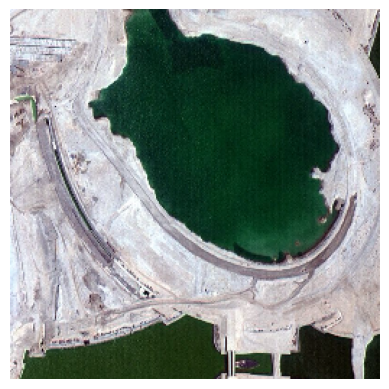

1/1 [==============================] - 0s 148ms/step
[7, 1, 3, 13, 28]


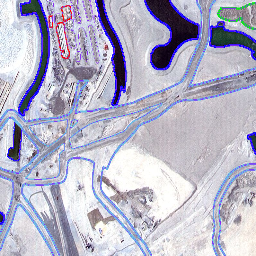

[0, 1, 2, 3, 4]


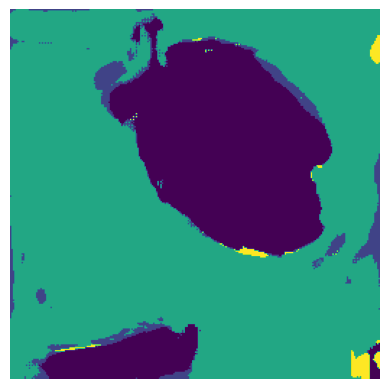

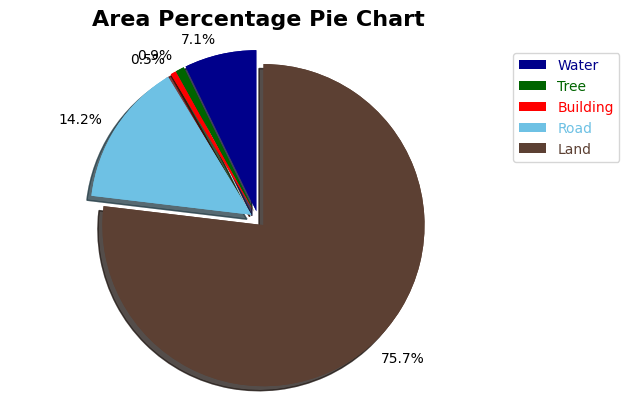

Report Year: 2011
╒═══════════════════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╕
│ Type of Information       │       Water │        Tree │    Building │        Road │        Land │
╞═══════════════════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ Number of regions         │     7       │    1        │    3        │     13      │     28      │
├───────────────────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ Area of regions (KM^2)    │ 71247.4     │ 8527.71     │ 5414.33     │ 142407      │ 756973      │
├───────────────────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ Percentage of regions (%) │     7.12474 │    0.852771 │    0.541433 │     14.2407 │     75.6973 │
╘═══════════════════════════╧═════════════╧═════════════╧═════════════╧═════════════╧═════════════╛


In [11]:
# Variable to store the uploaded image
uploaded_image = None
current_year=0
def gui():


    # Function to handle file selection event
    def on_file_upload(change):
        global uploaded_image  # Declare the variable as global

        uploaded_files = change['new']
        for file_name, file_info in uploaded_files.items():
            img_content = file_info['content']
            try:
                uploaded_image = Image.open(io.BytesIO(img_content))
                print('Image uploaded..')
                show_uploaded_image()
            except:
                print(f"Error: Invalid image file {file_name}")


    # Function to display the uploaded image
    def show_uploaded_image():
      if uploaded_image is not None:
        plt.axis('off')
        plt.imshow(cv2.resize(pil_to_cv2(uploaded_image), (256, 256)))
        plt.savefig('input_img.png')


    # Function to convert PIL image to CV2 image
    def pil_to_cv2(image):
        img_array = np.array(image)
        return cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)

    # Function to handle checkbox selection event
    def on_checkbox_change(change):
        selected_checkbox = change['owner']
        if selected_checkbox.value:
            print(f"Selected Option: {selected_checkbox.description}")
        else:
            print(f"Deselected Option: {selected_checkbox.description}")

    # Function to handle 'Generate Current Report Only' button click
    def generate_current_report(button):
        mask_res=predicted_mask(uploaded_image)
        plt.axis('off')
        plt.imshow(mask_res)
        plt.savefig('mask_res.png')
        img_loc='/content/drive/MyDrive/Group A.I. works/DubaiDataset/Tile 1/images/image_part_001.jpg'
        img=cv2.imread(img_loc)
        masks_loc='/content/drive/MyDrive/Group A.I. works/DubaiDataset/Tile 1/masks/image_part_001.png'
        masked_img=cv2.imread(masks_loc)
        generate_report(img,masked_img,current_year)

    # Function to handle 'Generate report & Compare with previous records' button click
    def generate_report_compare(button):
        clear_output()
        gui()

    # Function to handle 'Generate Suggestion' button click
    def generate_suggestion(button):
        print("Generating suggestion...")

    # Function to handle model selection event
    def on_model_select(change):
        selected_model = change['new']
        if selected_model == 'War Attack Analyzer':
            year_select_container.layout.display = 'none'
            buttons_container.layout.display = 'none'
            suggestion_container.layout.display = 'flex'
            role_dropdown.layout.display = 'flex'
            suggestion_button.layout.display = 'flex'
        else:
            year_select_container.layout.display = 'flex'
            buttons_container.layout.display = 'flex'
            suggestion_container.layout.display = 'none'
            role_dropdown.layout.display = 'none'
            suggestion_button.layout.display = 'none'

    # Create a file upload widget for the original image
    file_upload = widgets.FileUpload(
        accept='image/*',
        multiple=False,
        description='Upload Original Image',
        button_style='primary',
        style={'description_width': 'initial'}
    )

    # Create a file upload widget for the mask image
    mask_upload = widgets.FileUpload(
        accept='image/*',
        multiple=False,
        description='Upload Mask Image',
        button_style='primary',
        style={'description_width': 'initial'}
    )

    # Create a year selection dropdown widget
    years = range(2000, 2025)
    year_select = widgets.Dropdown(
        options=years,
        description='Select Year:',
        style={'description_width': 'initial'}
    )

    # Function to handle year selection event
    def on_year_select(change):
      global current_year
      current_year = change['new']
    # Register the event handler
    year_select.observe(on_year_select, names='value')

    # Create checkbox widgets
    tree_checkbox = widgets.Checkbox(description='Tree Detection')
    water_checkbox = widgets.Checkbox(description='Water Detection')
    building_checkbox = widgets.Checkbox(description='Building Detection')
    road_checkbox = widgets.Checkbox(description='Road Detection')
    freeland_checkbox = widgets.Checkbox(description='Free Land Detection')

    # Create buttons
    generate_current_button = widgets.Button(description='Generate Report', button_style='success')
    generate_compare_button = widgets.Button(description='Clear Report', button_style='success')
    suggestion_button = widgets.Button(description='Generate Suggestion', button_style='success')
    suggestion_button.layout.display = 'none'

    # Create ModelSelector dropdown
    model_selector = widgets.Dropdown(
        options=['Environment Analyzer', 'War Attack Analyzer'],
        description='Select Model:',
        style={'description_width': 'initial'}
    )

    # Create Role dropdown
    role_dropdown = widgets.Dropdown(
        options=['Attacker', 'Defender'],
        description='Your Role:',
        style={'description_width': 'initial'}
    )
    role_dropdown.layout.display = 'none'

    # Register the event handlers
    file_upload.observe(on_file_upload, names='value')
    mask_upload.observe(on_file_upload, names='value')
    tree_checkbox.observe(on_checkbox_change, names='value')
    water_checkbox.observe(on_checkbox_change, names='value')
    building_checkbox.observe(on_checkbox_change, names='value')
    road_checkbox.observe(on_checkbox_change, names='value')
    freeland_checkbox.observe(on_checkbox_change, names='value')
    generate_current_button.on_click(generate_current_report)
    generate_compare_button.on_click(generate_report_compare)
    suggestion_button.on_click(generate_suggestion)
    model_selector.observe(on_model_select, names='value')

    # Set the widget layout and style
    file_upload.layout.width = '500px'
    file_upload.layout.margin = '20px 0'
    mask_upload.layout.width = '500px'
    mask_upload.layout.margin = '20px 0'
    year_select.layout.width = '200px'
    generate_current_button.layout.margin = '10px'
    generate_compare_button.layout.margin = '10px 0'
    suggestion_button.layout.margin = '10px 0'
    model_selector.layout.width = '300px'

    # Apply custom styles to the widgets
    file_upload_button_style = {'button_color': '#4CAF50'}
    file_upload.style.button_color = file_upload_button_style['button_color']
    mask_upload.style.button_color = file_upload_button_style['button_color']
    generate_current_button.style.button_color = file_upload_button_style['button_color']
    generate_compare_button.style.button_color = '#1976D2'  # Blue color for the second button
    suggestion_button.style.button_color = '#1976D2'  # Blue color for the suggestion button
    checkbox_style = {'description_width': 'initial'}
    container_style = {'border': '2px solid #DDD', 'padding': '20px'}

    # Create a container to hold the checkboxes
    checkboxes_container = widgets.VBox([
        tree_checkbox,
        water_checkbox,
        building_checkbox,
        road_checkbox,
        freeland_checkbox
    ])

    # Create a container to hold the year selection
    year_select_container = widgets.VBox([
        year_select
    ])

    # Create a container to hold the buttons
    buttons_container = widgets.HBox([
        generate_current_button,
        generate_compare_button
    ])

    # Create a container to hold the suggestion button
    suggestion_container = widgets.VBox([
        suggestion_button
    ])

    # Create a container to hold the year selection and model selector
    selection_container = widgets.HBox([
        year_select_container,
        model_selector
    ])

    # Create a container to hold the role dropdown and suggestion button
    role_suggestion_container = widgets.HBox([
        role_dropdown,
        suggestion_button
    ])

    # Create a container to hold all the widgets
    container = widgets.VBox([
        file_upload,
        selection_container,
        checkboxes_container,
        buttons_container,
        role_suggestion_container
    ])

    # Apply custom styles to the container
    container.layout = widgets.Layout(**container_style)

    # Display the container
    display(container)
gui()